# Чтение данных

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

# Функция для чтения данных из .palm
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int = 50, 
                 n_acc_channels: int = 3, 
                 n_gyr_channels: int = 3,
                 n_enc_channels: int = 6,
                 n_mag_channels: int = 0, 
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Прочитаем все доступные данные
sprint1_pilote1_gestures = read_omg_csv('sprint1_pilote1_gestures.palm')
sprint2_pilote1_gestures = read_omg_csv('sprint2_pilote1_gestures.palm')
sprint2_pilote2_gestures = read_omg_csv('sprint2_pilote2_gestures.palm')
sprint3_pilote1_mount1_gestures = read_omg_csv('sprint3_pilote1_mount1_gestures.palm')
sprint3_pilote1_mount2_gestures = read_omg_csv('sprint3_pilote1_mount2_gestures.palm')

sprint1_pilote1_gestures_protocol = pd.read_csv('sprint1_pilote1_gestures.palm.protocol.csv')
sprint2_pilote1_gestures_protocol = pd.read_csv('sprint2_pilote1_gestures.palm.protocol.csv')
sprint2_pilote2_gestures_protocol = pd.read_csv('sprint2_pilote2_gestures.palm.protocol.csv')
sprint3_pilote1_mount1_gestures_protocol = pd.read_csv('sprint3_pilote1_mount1_gestures.palm.protocol.csv')
sprint3_pilote1_mount2_gestures_protocol = pd.read_csv('sprint3_pilote1_mount2_gestures.palm.protocol.csv')

sprint2_pilote1_fingers = read_omg_csv('sprint2_pilote1_fingers.palm')
sprint2_pilote2_fingers = read_omg_csv('sprint2_pilote2_fingers.palm')

# Определим маски признаков и таргетов
OMG_CH = [str(i) for i in range(50)]
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']

# Соединим данные 2-х пилотов
X_gestures = np.vstack([
    #sprint1_pilote1_gestures[OMG_CH].values,
    #sprint2_pilote1_gestures[OMG_CH].values,
    #sprint2_pilote2_gestures[OMG_CH].values,
    sprint3_pilote1_mount1_gestures[OMG_CH].values,
    sprint3_pilote1_mount2_gestures[OMG_CH].values,
    ])
y_gestures = np.vstack([
    #sprint1_pilote1_gestures[GLOVE_CH].values,
    #sprint2_pilote1_gestures[GLOVE_CH].values,
    #sprint2_pilote2_gestures[GLOVE_CH].values,
    sprint3_pilote1_mount1_gestures[GLOVE_CH].values,
    sprint3_pilote1_mount2_gestures[GLOVE_CH].values,
    ])

X_fingers = np.vstack([
    sprint2_pilote1_fingers[OMG_CH], 
    sprint2_pilote2_fingers[OMG_CH]
    ])
y_fingers = np.vstack([
    sprint2_pilote1_fingers[GLOVE_CH], 
    sprint2_pilote2_fingers[GLOVE_CH]
    ])

X_gestures.shape, y_gestures.shape, X_fingers.shape, y_fingers.shape

((39197, 50), (39197, 6), (31307, 50), (31307, 6))

# Определение основных функций

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_gestures, y_gestures)


In [4]:
def inference(array):
    return model.predict([array])[0]

def postprocessing(array, step=10):
    """_дискретизация выходных сигналов по 100/step количеству уровней
        по умолчанию step=10 -> 10 уровней сигналов_
    """
    array[array < 0] = 0
    array = np.round(array / step, 0).astype(int) * step
    array[array > 100] = 100
    return array

def commands(array, y_prev, times=2, step=10):
    """_Функция формирующая управляющие комманды
        по умолчанию происходит двухкратное последовательное срезание пиков 
        фильтром Холтом-Винтерсом с последующей дискретизация_        
    """
    if y_prev is None:
        return array
    else:
        if times == 1: #однократный срез пиков
            result = array*0.5 + y_prev*0.5
            result = np.round(array / step, 0).astype(int) * step
            result[result > 100] = 100
            return result
        elif times == 2: #двухкратный срез
            result = array*0.5 + y_prev*0.5
            result = postprocessing(result)
            result = result*0.6 + y_prev*0.4
            result = postprocessing(result)
            return result

# Эмуляция эмуляции `real-time inference`

In [6]:
import time

ts_diff_with_append = []
ts_diff_without_append = []

x_prev = None
y_prev = None
i = 0

y_pred_raw_lst = []
y_pred_post_lst = []
y_comm_lst = []

while i < X_gestures.shape[0]:
    
    ts_start = time.time()

    x = X_gestures[i]
    y_pred_raw = inference(x)
    y_pred_post = postprocessing(y_pred_raw)
    y_comm = commands(y_pred_post, y_prev, 2)
    y_prev = y_comm  
    x_prev = x
    
    ts_diff_without_append.append(time.time() - ts_start)
    
    y_pred_raw_lst.append(y_pred_raw)
    y_pred_post_lst.append(y_pred_post)
    y_comm_lst.append(y_comm)
    
    ts_diff_with_append.append(time.time() - ts_start)
    
    i += 1 
    
y_pred_raw_lst = np.array(y_pred_raw_lst)
y_pred_post_lst = np.array(y_pred_post_lst)
y_comm_lst = np.array(y_comm_lst)

Text(0.5, 1.0, 'ENC3, диапазон [18000:19000] дискретизация 10 по 10, ')

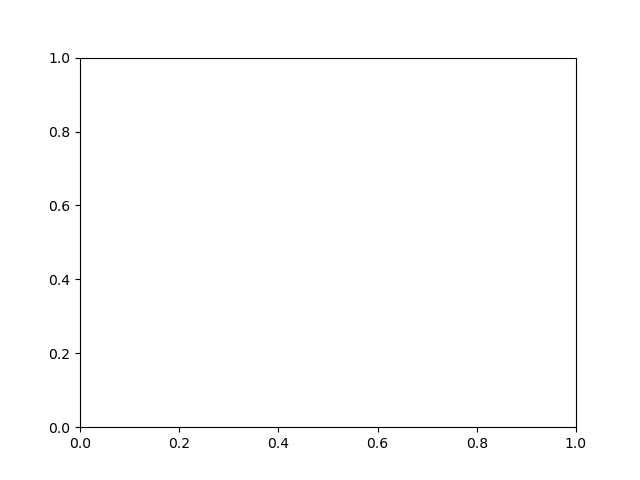

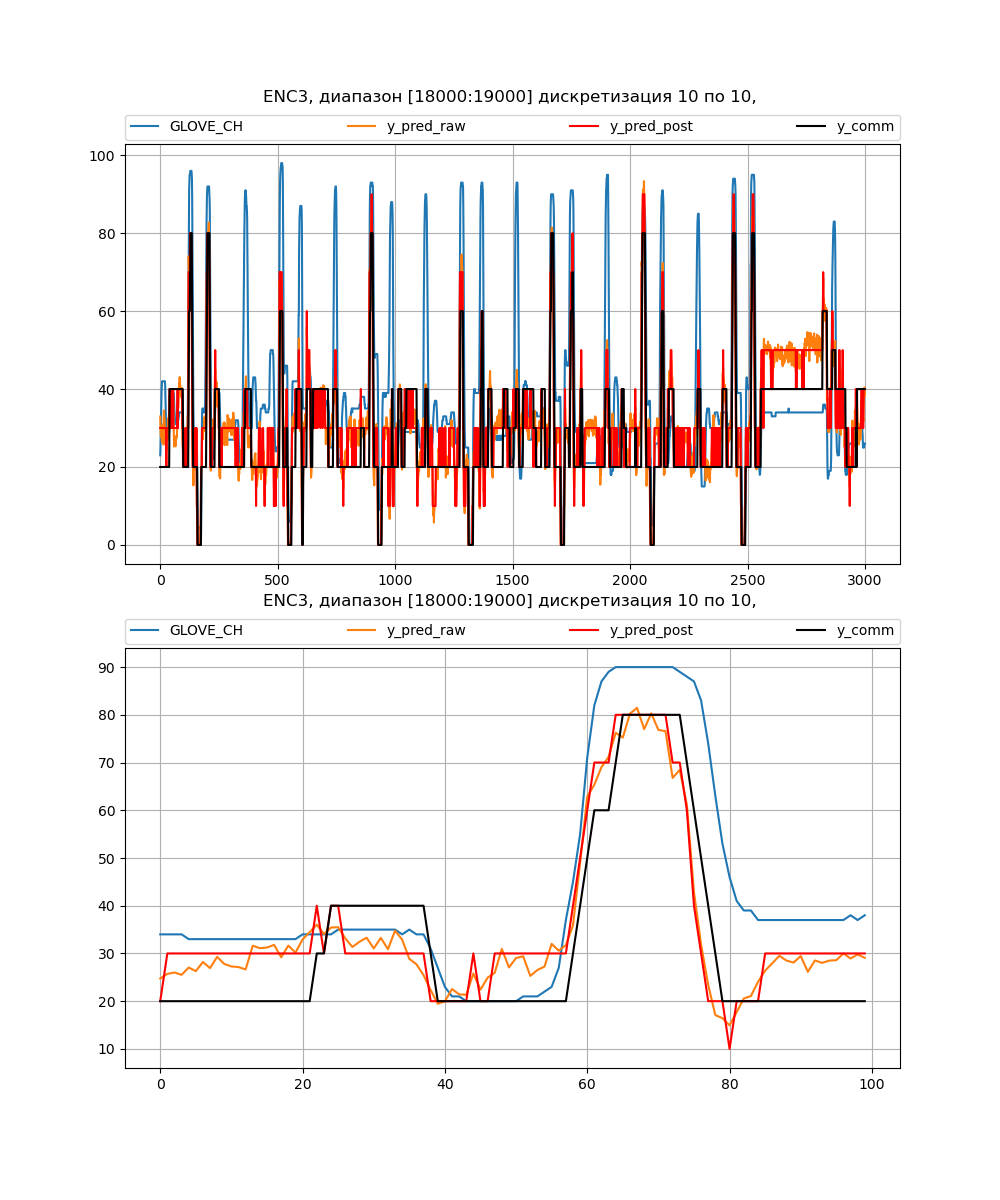

In [7]:
plt.clf()
plt.cla()
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

lines = []
labels = []

ax[0].plot(y_gestures[:,3][17000:20000], c='C0', label='GLOVE_CH')
ax[0].plot(y_pred_raw_lst[:,3][17000:20000], c='C1', label='y_pred_raw')
ax[0].plot(y_pred_post_lst[:,3][17000:20000], c='red', label='y_pred_post')
ax[0].plot(y_comm_lst[:,3][17000:20000], c='black', label='y_comm')
ax[0].legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left', ncols=5, mode="expand", borderaxespad=0.)
ax[0].grid()
ax[0].set_title("ENC3, диапазон [18000:19000] дискретизация 10 по 10, ", y=1.0, pad=30)
ax[1].plot(y_gestures[:,3][18600:18700], c='C0', label='GLOVE_CH')
ax[1].plot(y_pred_raw_lst[:,3][18600:18700], c='C1', label='y_pred_raw')
ax[1].plot(y_pred_post_lst[:,3][18600:18700], c='red', label='y_pred_post')
ax[1].plot(y_comm_lst[:,3][18600:18700], c='black', label='y_comm')
ax[1].legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left', ncols=5, mode="expand", borderaxespad=0.)
ax[1].grid()
ax[1].set_title("ENC3, диапазон [18000:19000] дискретизация 10 по 10, ", y=1.0, pad=30)

Text(0.5, 1.0, 'Отработка модели принятия решения в диапазоне [35000:] по каждому пальцу')

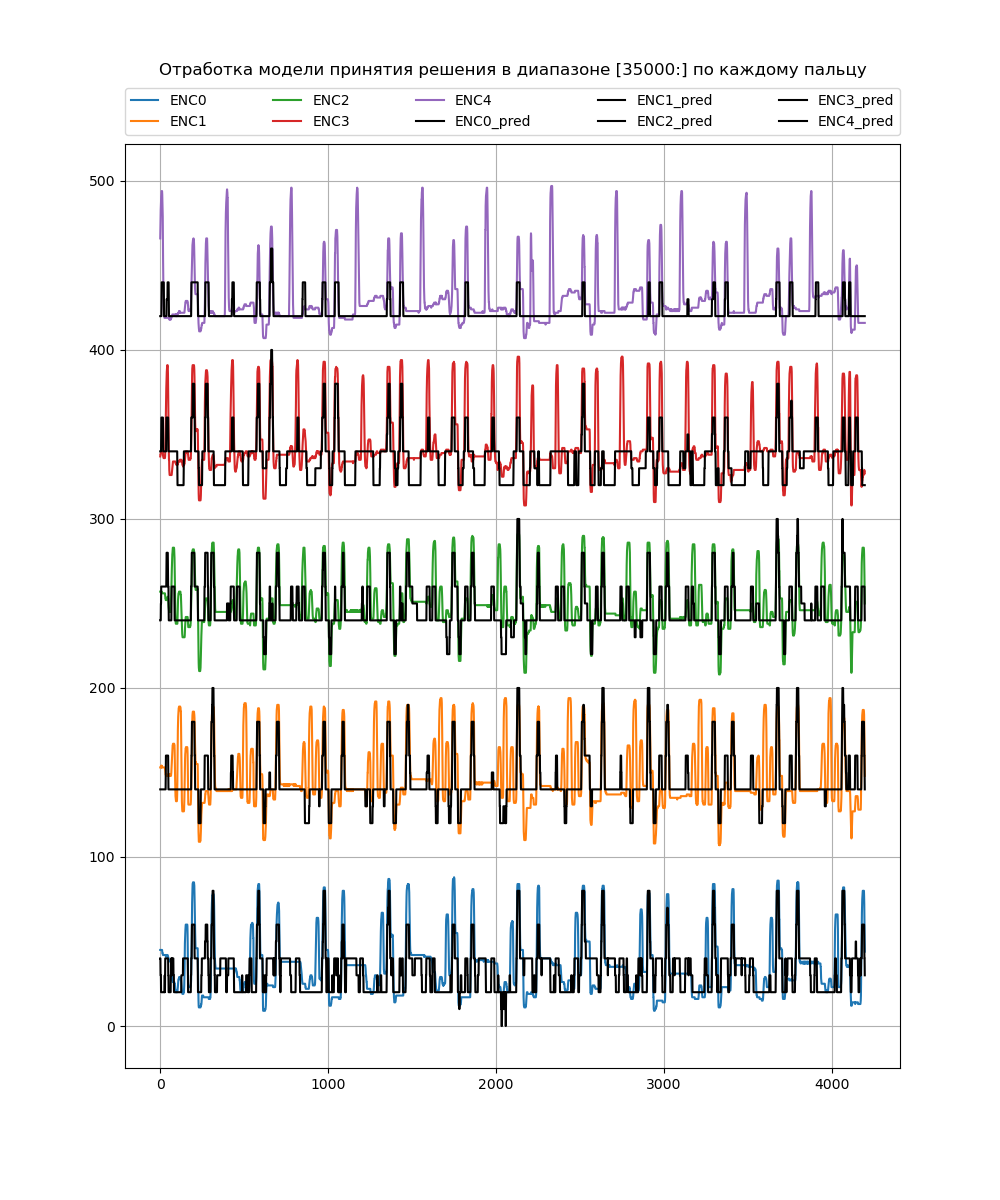

In [8]:
plt.clf()
plt.cla()
fig, ax = plt.subplots(figsize=(10, 12))

lines = []
labels = []

ax.plot(y_gestures[:,0][35000:], label='ENC0')
ax.plot(y_gestures[:,1][35000:] + 100, label='ENC1')
ax.plot(y_gestures[:,2][35000:] + 200, label='ENC2')
ax.plot(y_gestures[:,3][35000:] + 300, label='ENC3')
ax.plot(y_gestures[:,4][35000:] + 400, label='ENC4')

ax.plot(y_comm_lst[:,0][35000:], label='ENC0_pred', c='k')
ax.plot(y_comm_lst[:,1][35000:] + 100, label='ENC1_pred', c='k')
ax.plot(y_comm_lst[:,2][35000:] + 200, label='ENC2_pred', c='k')
ax.plot(y_comm_lst[:,3][35000:] + 300, label='ENC3_pred', c='k')
ax.plot(y_comm_lst[:,4][35000:] + 400, label='ENC4_pred', c='k')

ax.grid()
ax.legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left', ncols=5, mode="expand", borderaxespad=0.)
ax.set_title('Отработка модели принятия решения в диапазоне [35000:] по каждому пальцу', pad=50)

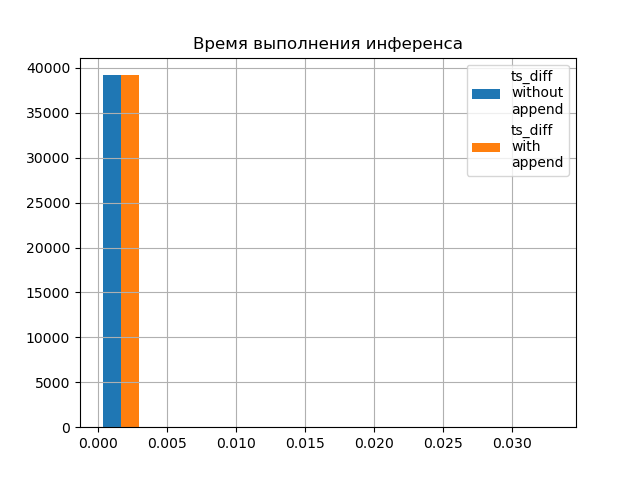

In [9]:
plt.clf()
plt.cla()
fig, ax = plt.subplots()
ax.hist([ts_diff_without_append, ts_diff_with_append])
ax.legend(['ts_diff\nwithout\nappend', 'ts_diff\nwith\nappend'])
ax.set_title('Время выполнения инференса')
ax.grid()

# Real-time inference

In [10]:
import time
#import serial
from IPython.display import clear_output

In [11]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [12]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(array):
    return model.predict([array])[0]

def postprocessing(array, step=10):
    """_дискретизация выходных сигналов по 100/step количеству уровней
        по умолчанию step=10 -> 10 уровней сигналов_
    """
    array[array < 0] = 0
    array = np.round(array / step, 0).astype(int) * step
    array[array > 100] = 100
    return array

def commands(array, y_prev, times=2, step=10):
    """_Функция формирующая управляющие комманды
        по умолчанию происходит двухкратное последовательное срезание пиков 
        фильтром Холтом-Винтерсом с последующей дискретизация_        
    """
    if y_prev is None:
        return array
    else:
        if times == 1: #однократный срез пиков
            result = array*0.5 + y_prev*0.5
            result = np.round(array / step, 0).astype(int) * step
            result[result > 100] = 100
            return result
        elif times == 2: #двухкратный срез
            result = array*0.5 + y_prev*0.5
            result = postprocessing(result)
            result = result*0.6 + y_prev*0.4
            result = postprocessing(result)
            return result

## Inference

### Offline (dataset)

In [13]:
sprint3_pilote1_mount2_gestures[OMG_CH]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,9,8,0,2,22,10,4,6,7,28,...,21,22,20,0,4,13,9,0,42,26
1,4,11,0,16,0,9,1,5,16,0,...,36,32,16,2,12,14,0,4,24,16
2,8,9,4,0,4,22,4,5,16,0,...,28,30,10,7,12,18,8,5,35,24
3,8,13,9,6,5,0,4,1,12,10,...,44,32,2,11,5,2,2,0,42,28
4,15,7,8,13,4,0,3,7,0,7,...,30,32,12,14,13,1,6,5,36,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19623,7,0,2,34,38,0,0,20,0,0,...,23,77,25,40,1,29,0,36,94,0
19624,17,9,0,0,25,14,15,13,26,20,...,26,19,3,19,4,24,6,1,41,12
19625,0,3,11,22,10,0,0,0,20,28,...,34,14,11,0,55,20,18,19,26,46
19626,0,0,2,18,32,22,18,30,65,30,...,25,24,16,21,4,6,7,9,39,30


In [14]:
df_sim = sprint3_pilote1_mount2_gestures.copy().iloc[:10000]
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(10000, 65)


In [15]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [16]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (10000, 50)
enc_sample.shape = (10000, 6)
sample_preprocessed.shape = (10000, 50)
y_predicted.shape = (10000, 6)
y_postprocessed.shape = (10000, 6)
y_commands.shape = (10000, 6)


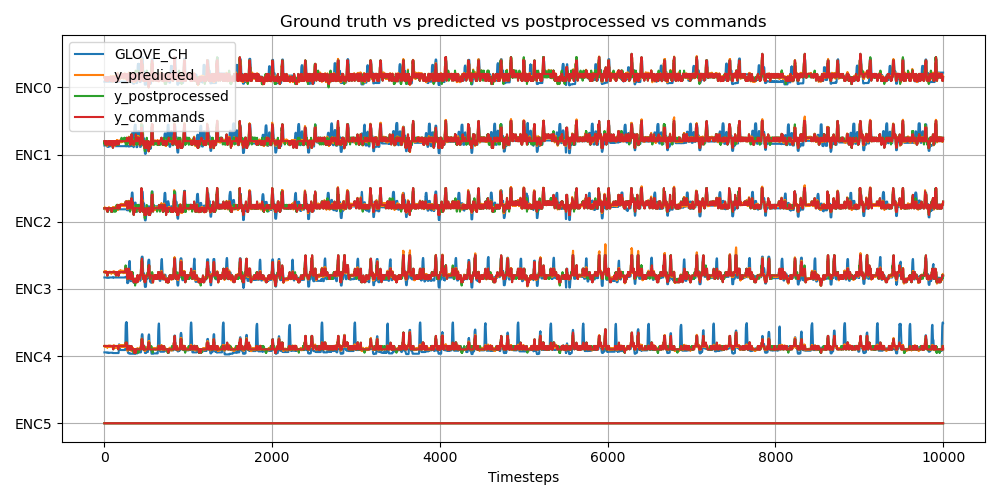

In [17]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SerialException: [Errno 2] could not open port /dev/cu.usbmodem3498365F31351: [Errno 2] No such file or directory: '/dev/cu.usbmodem3498365F31351'